In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from typing import Dict
import math
from tqdm.std import tqdm

from matplotlib import pyplot
import torch
import math
import torch.nn.functional as F
from torch import nn

from typing import Tuple, List
import torch
from torch import nn, Tensor

import torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,RandomSampler
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,roc_auc_score
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms, ToTensor, Resize, RandomVerticalFlip, RandomErasing
from matplotlib import pyplot as plt
import random
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt

import os
import glob
import os.path as osp
import cv2
from PIL import Image
from torchvision.transforms import Compose,ToTensor,Resize,RandomErasing,RandomHorizontalFlip,RandomVerticalFlip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/data.zip' -d '/content/data'

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
total_epochs= 10
number_of_samples= 5
learning_rate = 0.01
numEpoch = 4
batch_size = 32
momentum = 0.9
print_amount= 2

In [ ]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fw= torchvision.models.efficientnet_b0(pretrained=False)
        self.fw.features[0][0]=nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


        self.fw.classifier[1]=nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, 2),
        )

    def forward(self,x):

        return self.fw(x)

In [ ]:
def save_images(img, save_dir, prefix='image'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(img.size(0)):
        filename = os.path.join(save_dir, f"{prefix}_{i}.png")
        npimg = img[i].detach().cpu().numpy()
        print("=============", npimg.shape)
        npimg = np.transpose(npimg, (1, 2, 0))
        plt.imsave(filename, npimg)

In [ ]:
def train(model, train_loader, criterion, optimizer):

    model=model.to(device)
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in tqdm(train_loader, desc="Training"):
        data,target = data.to(device),target.to(device)

        # save_images(data, save_dir='images', prefix='batch')

        # Add Noise = 0.01
        # noise_level = 0.01
        # noise = torch.randn_like(data) * noise_level
        # data += noise
        # data = torch.clamp(data, 0, 1)

        # save_images(data, save_dir='images_noise', prefix='batch')

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()


    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [ ]:
def validation(
    model: nn.Module,
    test_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    relp: bool = False
) -> Tuple[float, float, Tensor, Tensor, Tensor]:
    """
    Validate the neural network model on test data.

    Parameters:
    - model (nn.Module): The neural network model to validate.
    - test_loader (DataLoader): The DataLoader for test data.
    - criterion (nn.Module): The loss function.
    - device (torch.device): The device to run the validation on.
    - relp (bool): Flag to return predictions and scores.

    Returns:
    - Tuple containing test loss, accuracy, labels, predictions, and scores.
    """
    model.eval()
    model = model.to(device)
    test_loss = 0.0
    correct = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            score = torch.softmax(output, dim=1)
            all_scores.append(score)
            prediction = score[:,1]
            all_preds.append(prediction)
            all_labels.append(target)
            threshold = 0.65
            prediction_class = (prediction >= threshold).int()
            correct += prediction_class.eq(target.int()).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    if relp:
        return test_loss, accuracy, torch.cat(all_labels, dim=0), torch.cat(all_preds, dim=0), torch.cat(all_scores, dim=0)
    return test_loss, accuracy

In [ ]:
def create_model_optimizer_criterion_dict(number_of_samples):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()

    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })

        optimizer_name="optimizer"+str(i)
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })

        criterion_name = "criterion"+str(i)
        criterion_info = nn.CrossEntropyLoss()
        criterion_dict.update({criterion_name : criterion_info})

    return model_dict, optimizer_dict, criterion_dict

In [ ]:
def get_averaged_weights(main_model:nn.Module,model_dict:dict,number_of_samples:int):
    state_dict={}
    for name ,param in tqdm(main_model.state_dict().items()):
        tmp_weights = torch.zeros(param.shape)
        for i in range(number_of_samples):
            tmp_weights = tmp_weights + model_dict['model'+str(i)].state_dict()[name].cpu()
        tmp_weights = tmp_weights/number_of_samples
        state_dict[name]= tmp_weights
    main_model.load_state_dict(state_dict)

In [ ]:
def send_main_model_to_nodes_and_update_model_dict(main_model:torch.nn.Module, model_dict:Dict[str,nn.Module], number_of_samples):
    for i in tqdm(range(number_of_samples)):
        model_dict["model"+str(i)].load_state_dict(main_model.state_dict())

In [ ]:
def start_train_end_node_process_without_print(number_of_samples):
    for i in range (number_of_samples):

        model=model_dict['model'+str(i)]
        criterion=criterion_dict['criterion'+str(i)]
        optimizer=optimizer_dict['optimizer'+str(i)]

        for epoch in range(numEpoch):
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)

In [ ]:
def start_train_end_node_process_print_some(number_of_samples, print_amount,):

    for i in range (number_of_samples):

        model=model_dict['model'+str(i)]
        criterion=criterion_dict['criterion'+str(i)]
        optimizer=optimizer_dict['optimizer'+str(i)]

        if i<print_amount:
            print("Subset" ,i)

        for epoch in range(numEpoch):

            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion, device, relp=False)

            if i<print_amount:
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [ ]:
class Data(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        label = int(file.split('class')[1][0])
        img = Image.open(file)
        if self.transform:
            img = self.transform(img)
        return img, label

def create_data_load(batch_size, drop_last, shuffle):
    import os
    all_files = glob.glob('/content/data/**/*.png', recursive=True)
    labels = [int(file.split('class')[1][0]) for file in all_files]

    train_files, test_files = train_test_split(all_files, test_size=0.2, stratify=labels, random_state=42)

    train_transform = Compose([ToTensor(), Resize((50, 50)), RandomVerticalFlip(), RandomErasing()])
    test_transform = Compose([ToTensor(), Resize((50, 50))])

    train_data = Data(train_files, transform=train_transform)
    test_data = Data(test_files, transform=test_transform)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)

    return train_dataloader, test_dataloader

train_dl, test_dl = create_data_load(batch_size, drop_last=True, shuffle=True)

In [ ]:
main_model = Net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples)

In [ ]:
print(next(main_model.parameters())[:2])
print(next(model_dict["model0"].parameters())[:2])

In [ ]:
send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

100%|██████████| 3/3 [00:00<00:00, 58.08it/s]


In [ ]:
print(next(main_model.parameters())[:2])
print(next(model_dict["model0"].parameters())[:2])

In [ ]:
def compute_metrics(scores, labels, threshold=0.5):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    predictions = [int(score >= threshold) for score in scores]

    p = precision_score(labels, predictions, average='macro')
    r = recall_score(labels, predictions, average='macro')
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return p, r, f1, acc, roc_auc

In [ ]:
start_train_end_node_process_print_some(number_of_samples, print_amount)

Subset 0


Training: 100%|██████████| 13876/13876 [14:30<00:00, 15.95it/s]


epoch:   1 | train accuracy: 0.85517 | test accuracy: 0.86568


Training: 100%|██████████| 13876/13876 [14:07<00:00, 16.38it/s]


epoch:   2 | train accuracy: 0.86855 | test accuracy: 0.85362


Training: 100%|██████████| 13876/13876 [13:59<00:00, 16.54it/s]


In [ ]:
get_averaged_weights(main_model,model_dict,number_of_samples)

100%|██████████| 360/360 [00:02<00:00, 177.50it/s]


100%|██████████| 3/3 [00:00<00:00, 47.81it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [14:08<00:00, 16.35it/s]


epoch:   1 | train accuracy: 0.86144 | test accuracy: 0.86085


Training: 100%|██████████| 13876/13876 [14:11<00:00, 16.30it/s]


epoch:   2 | train accuracy: 0.87193 | test accuracy: 0.86299


100%|██████████| 360/360 [00:01<00:00, 181.71it/s]


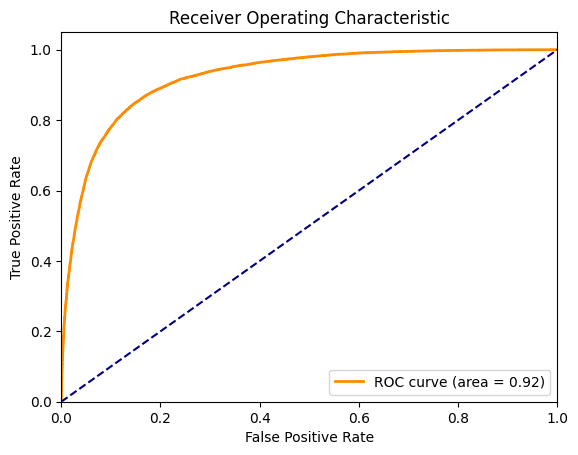

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test_loss: 0.015097302388214934
P: 0.35805077111559525 | R: 0.5 | F1: 0.4172838987721849 | Acc: 0.7161015422311905 | AUC: 0.9236628929430621


100%|██████████| 3/3 [00:00<00:00, 70.12it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [13:52<00:00, 16.67it/s]


epoch:   1 | train accuracy: 0.87425 | test accuracy: 0.86607


Training: 100%|██████████| 13876/13876 [14:38<00:00, 15.79it/s]


epoch:   2 | train accuracy: 0.87791 | test accuracy: 0.86965


100%|██████████| 360/360 [00:02<00:00, 134.43it/s]


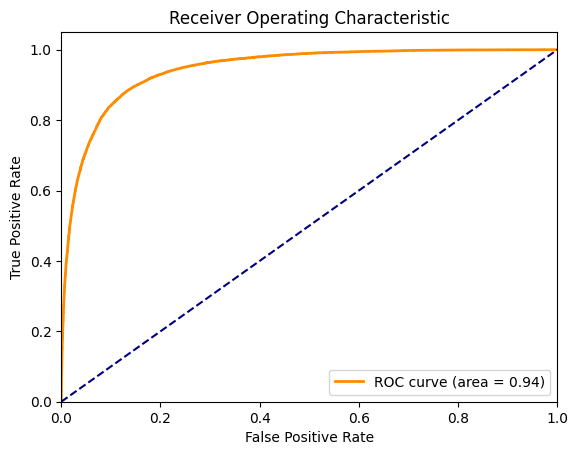

test_loss: 0.009239114286912774
P: 0.8744861873157452 | R: 0.8118426197919906 | F1: 0.835125481651548 | Acc: 0.8763782790429518 | AUC: 0.9444093196043001


100%|██████████| 3/3 [00:00<00:00, 46.53it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [13:33<00:00, 17.05it/s]


epoch:   1 | train accuracy: 0.88275 | test accuracy: 0.86425


Training: 100%|██████████| 13876/13876 [14:24<00:00, 16.06it/s]


epoch:   2 | train accuracy: 0.88487 | test accuracy: 0.87204


100%|██████████| 360/360 [00:02<00:00, 164.18it/s]


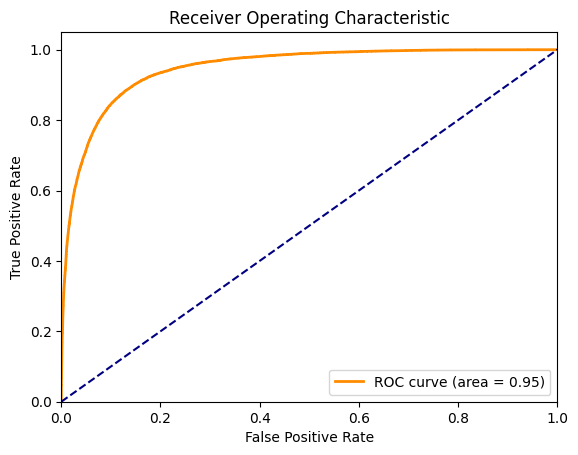

test_loss: 0.00843245105088192
P: 0.8743464571182396 | R: 0.8225309316209566 | F1: 0.8428353201511696 | Acc: 0.8805221245315653 | AUC: 0.9464297855159369


100%|██████████| 3/3 [00:00<00:00, 67.39it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [13:56<00:00, 16.60it/s]


epoch:   1 | train accuracy: 0.89010 | test accuracy: 0.87534


Training: 100%|██████████| 13876/13876 [13:27<00:00, 17.18it/s]


epoch:   2 | train accuracy: 0.89254 | test accuracy: 0.87479


100%|██████████| 360/360 [00:02<00:00, 146.64it/s]


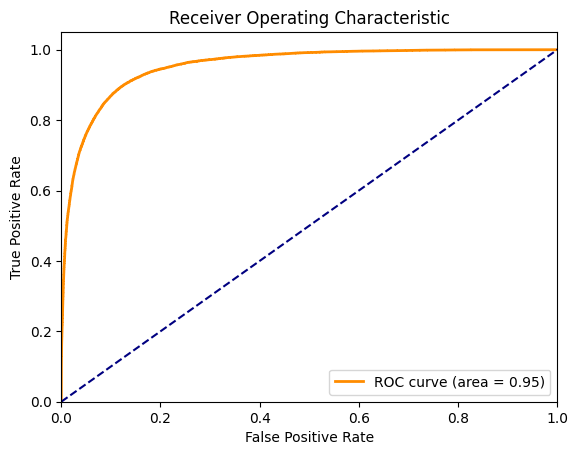

test_loss: 0.007755657496633331
P: 0.8859777237864589 | R: 0.8466959273577236 | F1: 0.8631682885517185 | Acc: 0.8941337561256847 | AUC: 0.9540276192944361


100%|██████████| 3/3 [00:00<00:00, 61.65it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [15:21<00:00, 15.06it/s]


epoch:   1 | train accuracy: 0.89106 | test accuracy: 0.87005


Training: 100%|██████████| 13876/13876 [15:19<00:00, 15.09it/s]


epoch:   2 | train accuracy: 0.89446 | test accuracy: 0.89013


100%|██████████| 360/360 [00:02<00:00, 146.45it/s]


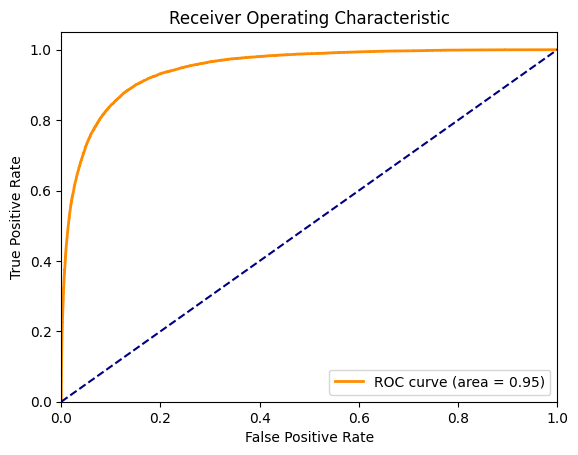

test_loss: 0.008515847458564294
P: 0.8838818862605338 | R: 0.7787012207954538 | F1: 0.8104756431186682 | Acc: 0.8649466705102336 | AUC: 0.9463477553552198


100%|██████████| 3/3 [00:00<00:00, 58.73it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [15:49<00:00, 14.62it/s]


epoch:   1 | train accuracy: 0.89870 | test accuracy: 0.87621


Training: 100%|██████████| 13876/13876 [15:45<00:00, 14.67it/s]


epoch:   2 | train accuracy: 0.89501 | test accuracy: 0.86856


100%|██████████| 360/360 [00:02<00:00, 150.35it/s]


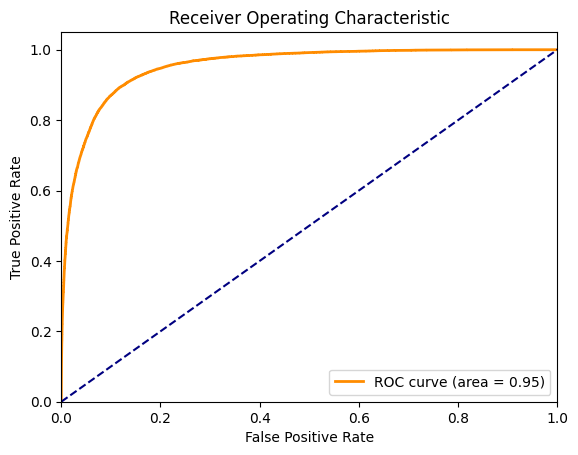

test_loss: 0.008173763858027398
P: 0.8767772247115502 | R: 0.8618926422483626 | F1: 0.8688378585331511 | Acc: 0.8954039348515422 | AUC: 0.9535694398040537


100%|██████████| 3/3 [00:00<00:00, 62.74it/s]


Subset 0


Training: 100%|██████████| 13876/13876 [14:47<00:00, 15.63it/s]


epoch:   1 | train accuracy: 0.89925 | test accuracy: 0.89094


Training:  93%|█████████▎| 12958/13876 [14:18<00:55, 16.44it/s]

In [ ]:
for epoch_ in range(total_epochs):
    send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_print_some(number_of_samples, print_amount)
    get_averaged_weights(main_model,model_dict,number_of_samples)

    test_loss, correct, label, preds, scores = validation(main_model, test_dl, main_criterion, device, relp=True)
    p, r, f1, acc, roc_auc = compute_metrics(preds.cpu().numpy(), label.cpu().numpy(), threshold=0.65)
    print("test_loss:",test_loss)
    print(f"P: {p} | R: {r} | F1: {f1} | Acc: {acc} | AUC: {roc_auc}")